Importing libraries :

In [ ]:
import os
import io
import sys
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, silhouette_score

try:
    from xgboost import XGBClassifier
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

# Optional settings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

# Output folder
os.makedirs('project_outputs', exist_ok=True)

Loading the dataset :

In [ ]:
# Loading the dataset
df = pd.read_csv("Banking_LP.csv")
print(df.head())

   annual_income  credit_utilization_ratio  num_credit_cards  \
0  477649.237999                  1.000000                 0   
1  475617.310144                  0.035161                 1   
2  297890.629959                  0.770608                 1   
3  464066.864714                  1.000000                 1   
4  490062.049245                  0.071669                 1   

   avg_transaction_amount    loan_amount  monthly_expenses  account_balance  \
0             7745.032372  364947.204474      16606.219676    160434.685075   
1            24083.821801  384213.793102      68566.086449    198807.943750   
2            10322.717098  218348.137244       9989.284671    214289.819418   
3            11464.994739  104624.813186     100488.748048     77230.329827   
4             1987.974758  149299.859579      68789.890541     65847.375393   

   declared_income  debt_to_income_ratio occupation_type has_defaulted  \
0    459038.488591              1.000000               C          

Data Cleaning and Preparation :

- The dataset is cleaned to ensure accuracy and reliability.
- Missing values are handled by replacing them with the median for numerical columns and the mode for categorical columns, preserving the overall distribution of the data.
- Outliers are detected and removed using the Interquartile Range (IQR) method to prevent skewness and improve model stability.
- Data types are validated and converted where necessary for optimal processing efficiency.
- The cleaned dataset is then verified to ensure consistency and readiness for further analysis.

In [ ]:
# Convert common binary string values to numeric 0/1
for col in df.columns:
    if df[col].dtype == object:
        unique_vals = set(df[col].dropna().unique())
        if unique_vals <= {"Yes","No"} or unique_vals <= {"Y","N"} or unique_vals <= {"yes","no"}:
            df[col] = df[col].map({"Yes":1,"No":0,"Y":1,"N":0,"yes":1,"no":0})

# Drop rows with missing target if present
if 'responded_to_offer' in df.columns:
    df.dropna(subset=['responded_to_offer'], inplace=True)


In [ ]:
# Making a copy of raw data
df_raw = df.copy()

# Converting binary columns (Yes/No) to 0/1
for col in df.columns:
    if df[col].dtype == object:
        unique_vals = set(df[col].dropna().unique())
        if unique_vals <= {"Yes","No"} or unique_vals <= {"Y","N"} or unique_vals <= {"yes","no"}:
            df[col] = df[col].map({"Yes":1,"No":0,"Y":1,"N":0,"yes":1,"no":0})

# IQR Outlier Removal (numeric columns except target)
num_cols_initial = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols_iqr = [c for c in num_cols_initial if c != 'responded_to_offer']

for col in num_cols_iqr:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

# Handle missing values
# Numeric columns → median
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Categorical columns → mode
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])


# Shape of the DataFrame
print("DataFrame shape after cleaning:", df.shape)

# Total missing values
print("Remaining missing values:", df.isnull().sum().sum())

# First 5 rows of entire dataset
print("\nFirst 5 rows of the dataset:")
print(df.head().to_string())

# Numeric columns first 5 rows
num_cols = df.select_dtypes(include=[np.number]).columns
if len(num_cols) > 0:
    print("\nNumeric columns (first 5 rows):")
    print(df[num_cols].head().to_string())

# Categorical columns first 5 rows
cat_cols = df.select_dtypes(include=['object']).columns
if len(cat_cols) > 0:
    print("\nCategorical columns (first 5 rows):")
    print(df[cat_cols].head().to_string())

DataFrame shape after cleaning: (4487, 12)
Remaining missing values: 0

First 5 rows of the dataset:
   annual_income  credit_utilization_ratio  num_credit_cards  avg_transaction_amount    loan_amount  monthly_expenses  account_balance  declared_income  debt_to_income_ratio occupation_type  has_defaulted  responded_to_offer
0  477649.237999                  1.000000                 0             7745.032372  364947.204474      16606.219676    160434.685075    459038.488591              1.000000               C              0                   1
2  297890.629959                  0.770608                 1            10322.717098  218348.137244       9989.284671    214289.819418    278163.250246              0.715712               B              0                   1
3  464066.864714                  1.000000                 1            11464.994739  104624.813186     100488.748048     77230.329827    459639.116200              0.792329               B              1                   0

Data Preprocessing :

- Data preprocessing prepares raw data for analysis or machine learning by ensuring it is clean, consistent, and properly formatted.
- It begins with data cleaning, including handling missing values, correcting errors, and converting categorical or binary features into numeric formats.
- Next, feature transformation scales continuous numeric columns, encodes categorical variables via One-Hot Encoding, and preserves binary features as 0/1.
- The resulting dataset is fully numeric, standardized, and ready for modeling, with features that are comparable, interpretable, and optimized for algorithm performance.
- Finally, the preprocessed data is inspected to confirm that transformations are correct and suitable for the project’s objectives.

In [ ]:
# One-Hot Encoding + Binary Passthrough + Scale Continuous Numeric Columns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

# Defining target column
target_col = 'responded_to_offer' if 'responded_to_offer' in df.columns else None

# Identifying categorical and numeric columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols = [c for c in cat_cols if c != target_col]

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

# Separating numeric columns into binary and continuous
binary_cols = [c for c in numeric_cols if df[c].nunique() == 2]
cont_cols = [c for c in numeric_cols if c not in binary_cols]

# Printing column categories
print("Categorical columns (to OHE):", cat_cols)
print("Binary numeric columns (kept as 0/1):", binary_cols)
print("Continuous numeric columns (to scale):", cont_cols)

# Building ColumnTransformer
transformers = []
if cont_cols:
    transformers.append(('num', StandardScaler(), cont_cols))
if binary_cols:
    transformers.append(('bin', 'passthrough', binary_cols))
if cat_cols:
    transformers.append(('cat', OneHotEncoder(sparse_output=False, drop='first'), cat_cols))

ct = ColumnTransformer(transformers=transformers, remainder='drop')

# Applying transformations
arr = ct.fit_transform(df)

# Creating column names for transformed DataFrame
cols_after = []
if cont_cols:
    cols_after += cont_cols
if binary_cols:
    cols_after += binary_cols
if cat_cols:
    cols_after += list(ct.named_transformers_['cat'].get_feature_names_out(cat_cols))

# Building processed DataFrame
df_proc = pd.DataFrame(arr, columns=cols_after, index=df.index)
if target_col:
    df_proc[target_col] = df[target_col].values

# Outputing the summary
print("DataFrame shape after cleaning:", df_proc.shape)
print("Remaining missing values:", df_proc.isnull().sum().sum())

print("\nFirst 5 rows of the dataset:")
print(df_proc.head().to_string())

# Separating numeric and categorical columns
numeric_cols = df_proc.select_dtypes(include=[np.number]).columns
categorical_cols = df_proc.select_dtypes(include=['object', 'category']).columns

# Printing numeric columns (first 5 rows)
if len(numeric_cols) > 0:
    print("\nNumeric columns (first 5 rows):")
    print(df_proc[numeric_cols].head().to_string())

# Printing categorical columns (first 5 rows)
if len(categorical_cols) > 0:
    print("\nCategorical columns (first 5 rows):")
    print(df_proc[categorical_cols].head().to_string())

# Save a sample
df_proc.head().to_csv('project_outputs/processed_data_sample.csv', index=False)



Categorical columns (to OHE): ['occupation_type']
Binary numeric columns (kept as 0/1): ['has_defaulted']
Continuous numeric columns (to scale): ['annual_income', 'credit_utilization_ratio', 'num_credit_cards', 'avg_transaction_amount', 'loan_amount', 'monthly_expenses', 'account_balance', 'declared_income', 'debt_to_income_ratio']
DataFrame shape after cleaning: (4487, 13)
Remaining missing values: 0

First 5 rows of the dataset:
   annual_income  credit_utilization_ratio  num_credit_cards  avg_transaction_amount  loan_amount  monthly_expenses  account_balance  declared_income  debt_to_income_ratio  has_defaulted  occupation_type_B  occupation_type_C  responded_to_offer
0       1.965141                  0.936902         -1.347977                0.065291     0.349298         -1.042995         0.291449         1.661074              1.070458            0.0                0.0                1.0                   1
2      -0.283190                  0.252330         -0.250269               

Clustering :

- The optimal number of clusters (k) is determined using both the Elbow Method and the Silhouette Score to ensure robustness in the selection process.
- The Elbow Method identifies the point where adding more clusters yields diminishing returns in reducing within-cluster variance.
- The Silhouette Score evaluates cluster cohesion and separation, ensuring that the chosen k produces well-defined and contextually meaningful groupings.
- Once k is finalized, the KMeans algorithm partitions the dataset into well-defined clusters, uncovering underlying patterns and meaningful relationships within the data.
- The resulting clusters are analyzed for interpretability and alignment with the project’s objectives.

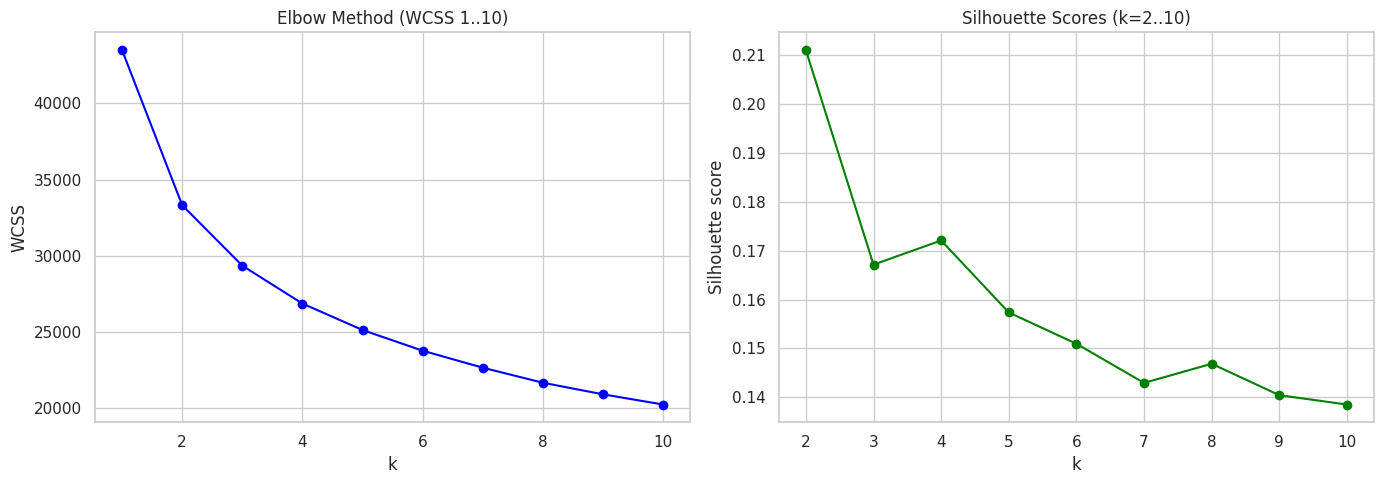

Clustering input check:
Means:
 annual_income               0.00
credit_utilization_ratio   -0.00
num_credit_cards            0.00
avg_transaction_amount      0.00
loan_amount                -0.00
monthly_expenses           -0.00
account_balance            -0.00
declared_income             0.00
debt_to_income_ratio       -0.00
has_defaulted               0.49
occupation_type_B           0.34
occupation_type_C           0.33
dtype: float64

Standard Deviations:
 annual_income               1.00
credit_utilization_ratio    1.00
num_credit_cards            1.00
avg_transaction_amount      1.00
loan_amount                 1.00
monthly_expenses            1.00
account_balance             1.00
declared_income             1.00
debt_to_income_ratio        1.00
has_defaulted               0.50
occupation_type_B           0.47
occupation_type_C           0.47
dtype: float64

Silhouette scores (k=2..10):
k=2: 0.2111
k=3: 0.1671
k=4: 0.1721
k=5: 0.1574
k=6: 0.1509
k=7: 0.1429
k=8: 0.1468
k=9: 0.14

In [ ]:
# Clustering analysis - Elbow & Silhouette
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Features for clustering (drop target)
features_for_clustering = df_proc.drop(columns=[target_col], errors='ignore')

# Computing WCSS for Elbow method (k=1..10)
wcss = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(features_for_clustering)
    wcss.append(km.inertia_)

# Computing Silhouette scores (k=2..10)
sil_scores = []
ks = list(range(2, 11))
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(features_for_clustering)
    sil_scores.append(silhouette_score(features_for_clustering, labels))

# Plotting both graphs
fig, ax = plt.subplots(1, 2, figsize=(14,5))

# Elbow plot
ax[0].plot(range(1, 11), wcss, marker='o', color='blue')
ax[0].set_title('Elbow Method (WCSS 1..10)')
ax[0].set_xlabel('k')
ax[0].set_ylabel('WCSS')
ax[0].grid(True)

# Silhouette plot
ax[1].plot(ks, sil_scores, marker='o', color='green')
ax[1].set_title('Silhouette Scores (k=2..10)')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette score')
ax[1].grid(True)

plt.tight_layout()
plt.savefig('project_outputs/clustering_elbow_silhouette.png', dpi=120)
plt.show()

# Printing clustering input summary
print("Clustering input check:")
print("Means:\n", features_for_clustering.mean().round(2))
print("\nStandard Deviations:\n", features_for_clustering.std().round(2))

# Printing Silhouette scores
print("\nSilhouette scores (k=2..10):")
for k, s in zip(ks, sil_scores):
    print(f"k={k}: {s:.4f}")


In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# 1. Auto-select optimal k (highest silhouette score)
optimal_k = int(np.argmax(sil_scores) + 2)  # +2 because silhouette list starts at k=2
print("Auto-selected optimal_k (highest silhouette):", optimal_k)

# 2. Fit final KMeans and assign clusters
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_proc['Cluster'] = kmeans_final.fit_predict(features_for_clustering)

# 3. Print cluster counts (clean format)
print("Assigned cluster counts :")
cluster_counts = df_proc['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster} : {count}")

Auto-selected optimal_k (highest silhouette): 2
Assigned cluster counts :
Cluster 0 : 2332
Cluster 1 : 2155


Results Analysis and Visualization :

- The collected model performance metrics are organized into a structured DataFrame to enable clear interpretation.
- A bar chart is generated to visually compare the accuracy of different models across each cluster, highlighting performance variations.
- The best-performing model for every cluster is identified using maximum accuracy as the selection criterion, providing a concise summary of optimal results.
- The complete performance table, containing accuracy, F1 score, and ROC AUC for all models and clusters, is exported to a CSV file for record keeping and future reference.
- This step ensures the outcomes of the training process are not only measured but also communicated effectively through both visual and tabular formats.

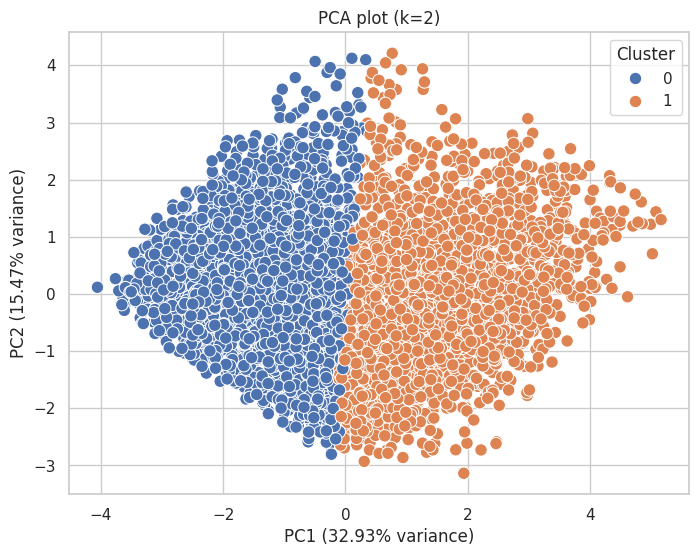

In [ ]:
# PCA visualization of clusters (2 components) with variance in axis labels
pca = PCA(n_components=2)
pca_feats = pca.fit_transform(features_for_clustering)
pca_df = pd.DataFrame(pca_feats, columns=['PC1','PC2'], index=df_proc.index)
pca_df['Cluster'] = df_proc['Cluster'].values

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='deep', s=80)
plt.title(f'PCA plot (k={optimal_k})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend(title='Cluster')
plt.savefig('project_outputs/pca_cluster_plot.png', dpi=120)
plt.show()

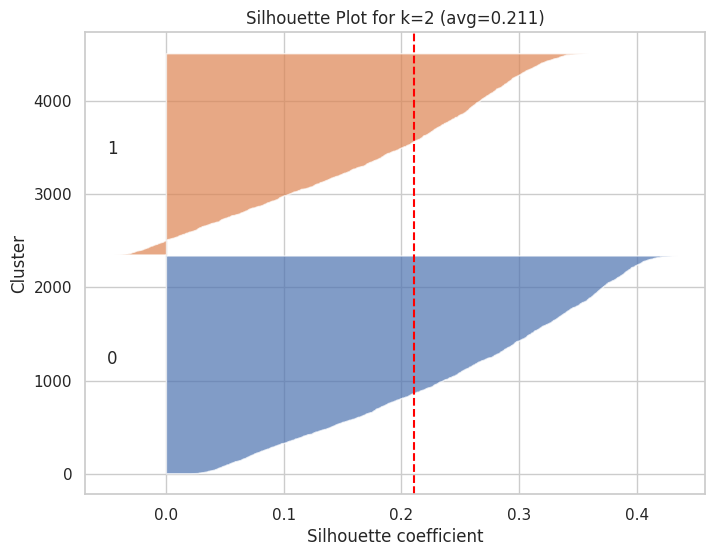

Average silhouette : 0.21110330427577592


In [ ]:
# Silhouette plot for optimal_k (silhouette_samples per cluster)
from sklearn.metrics import silhouette_samples
sil_avg = silhouette_score(features_for_clustering, df_proc['Cluster'])
sil_vals = silhouette_samples(features_for_clustering, df_proc['Cluster'])

plt.figure(figsize=(8,6))
y_lower = 10
for i in range(optimal_k):
    ith_cluster_silhouette_values = sil_vals[df_proc['Cluster']==i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
plt.axvline(x=sil_avg, color='red', linestyle='--')
plt.title(f'Silhouette Plot for k={optimal_k} (avg={sil_avg:.3f})')
plt.xlabel('Silhouette coefficient')
plt.ylabel('Cluster')
plt.savefig('project_outputs/silhouette_plot_optimal.png', dpi=120)
plt.show()
print("Average silhouette :", sil_avg)

Cluster profile (slide summary):
         Response Rate  Median Income  Avg Debt/Income  Avg Credit Cards
Cluster                                                                 
0             0.525729      -0.603157        -0.721363         -0.162716
1             0.466357       0.460624         0.780612          0.176080


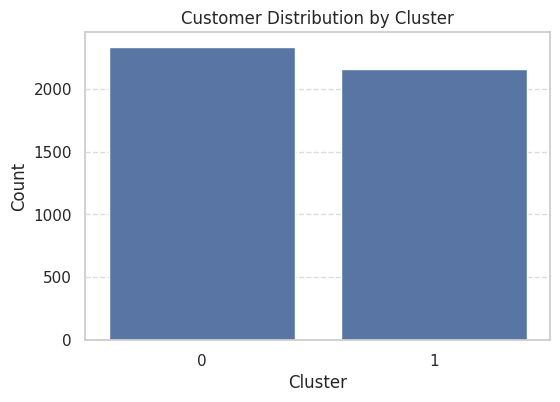

In [ ]:
# Cluster profiles (summary table + distribution bar)

import matplotlib.pyplot as plt
import seaborn as sns

# Selecting columns for profiling
profile_cols = []
possible_profile_cols = ['annual_income','debt_to_income_ratio','num_credit_cards','responded_to_offer',
                         'avg_transaction_amount','loan_amount','monthly_expenses','account_balance','declared_income']
for c in possible_profile_cols:
    if c in df_proc.columns:
        profile_cols.append(c)

# Including one-hot occupation/default columns if present
ohe_cols = [c for c in df_proc.columns if c.startswith('occupation_type_') or c.startswith('has_defaulted_') or c.startswith('has_defaulted')]
profile_cols += [c for c in ohe_cols if c not in profile_cols]

# Detailed cluster profile (median + mean)
cluster_profile = df_proc.groupby('Cluster')[profile_cols].agg(['median','mean'])

# Slide-friendly summary
slide_summary = df_proc.groupby('Cluster').agg({
    'responded_to_offer':'mean',
    **{c: 'median' for c in ['annual_income'] if c in df_proc.columns},
    **{c: 'mean' for c in ['debt_to_income_ratio','num_credit_cards'] if c in df_proc.columns}
}).rename(columns={
    'responded_to_offer':'Response Rate',
    'annual_income':'Median Income',
    'debt_to_income_ratio':'Avg Debt/Income',
    'num_credit_cards':'Avg Credit Cards'
})

# Printing summary in normal format
print("Cluster profile (slide summary):")
print(slide_summary.to_string())

# Save summary CSV
slide_summary.to_csv('project_outputs/cluster_profile_summary.csv')

# Cluster distribution bar
plt.figure(figsize=(6,4))
sns.countplot(x='Cluster', data=df_proc)
plt.title('Customer Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('project_outputs/cluster_distribution.png', dpi=120)
plt.show()

In [ ]:
# Modeling per cluster with CV (Logistic, DecisionTree, SVM, RandomForest, XGBoost)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

# Defining models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42)
}
if _HAS_XGB:
    models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Preparing results list
detailed_results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Looping through clusters
for cluster in sorted(df_proc['Cluster'].unique()):
    cluster_data = df_proc[df_proc['Cluster']==cluster]
    if target_col not in cluster_data.columns:
        print("No target present; skipping modeling.")
        break
    X = cluster_data.drop(columns=[target_col,'Cluster'], errors='ignore')
    y = cluster_data[target_col].astype(int)

    if len(y.unique()) < 2 or len(y) < 30:
        print(f"Skipping cluster {cluster}: too few samples or single class (n={len(y)}, classes={y.unique()})")
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

    for name, model in models.items():
        model.fit(X_train, y_train)

        # Train/test AUC
        try:
            train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
            test_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        except Exception:
            train_auc = np.nan
            test_auc = np.nan

        # CV AUC
        try:
            cv_scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
            cv_mean, cv_std = cv_scores.mean(), cv_scores.std()
        except Exception:
            cv_mean, cv_std = np.nan, np.nan

        detailed_results.append({
            'Cluster': cluster, 'Model': name,
            'Train AUC': train_auc, 'Test AUC': test_auc,
            'CV AUC Mean': cv_mean, 'CV AUC Std': cv_std,
            'Train Size': X_train.shape[0], 'Test Size': X_test.shape[0],
            'Train Acc': model.score(X_train, y_train), 'Test Acc': model.score(X_test, y_test)
        })

# Converting to DataFrame for saving
detailed_df = pd.DataFrame(detailed_results)
detailed_df.to_csv('project_outputs/model_perf_detailed.csv', index=False)

# Printing results in normal font (plain text)
print("Modeling complete. Sample of results :\n")
print(detailed_df.head(20).to_string(index=False))


Modeling complete. Sample of results :

 Cluster               Model  Train AUC  Test AUC  CV AUC Mean  CV AUC Std  Train Size  Test Size  Train Acc  Test Acc
       0 Logistic Regression   0.759549  0.735200     0.746450    0.014247        1749        583   0.694683  0.691252
       0       Decision Tree   1.000000  0.648876     0.650470    0.017106        1749        583   1.000000  0.650086
       0                 SVM   0.848812  0.787417     0.803294    0.023108        1749        583   0.783305  0.728988
       0       Random Forest   1.000000  0.787275     0.795593    0.021836        1749        583   1.000000  0.708405
       0             XGBoost   1.000000  0.780586     0.775202    0.027102        1749        583   0.999428  0.703259
       1 Logistic Regression   0.924208  0.938759     0.925654    0.017633        1616        539   0.881188  0.883117
       1       Decision Tree   1.000000  0.832289     0.832250    0.020756        1616        539   1.000000  0.831169
       1

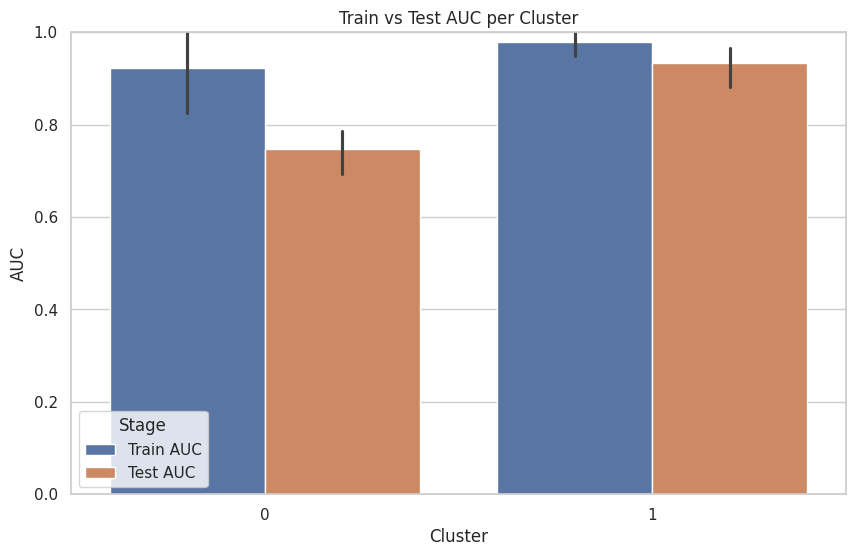

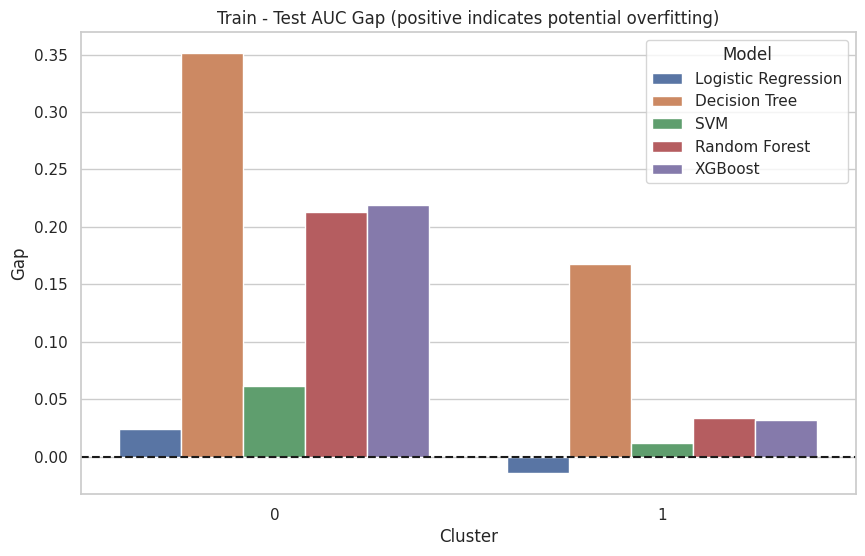

In [ ]:
# Performance visuals (Train vs Test AUC & Train-Test Gap)
if not detailed_df.empty:
    # Train vs Test AUC
    plt.figure(figsize=(10,6))
    df_melt = detailed_df.melt(id_vars=['Cluster','Model'], value_vars=['Train AUC','Test AUC'], var_name='Stage', value_name='AUC')
    sns.barplot(data=df_melt, x='Cluster', y='AUC', hue='Stage')
    plt.ylim(0,1)
    plt.title('Train vs Test AUC per Cluster')
    plt.savefig('project_outputs/train_vs_test_auc.png', dpi=120)
    plt.show()

    # Train-Test gap
    detailed_df['Gap'] = detailed_df['Train AUC'] - detailed_df['Test AUC']
    plt.figure(figsize=(10,6))
    sns.barplot(data=detailed_df, x='Cluster', y='Gap', hue='Model')
    plt.axhline(0, color='k', linestyle='--')
    plt.title('Train - Test AUC Gap (positive indicates potential overfitting)')
    plt.savefig('project_outputs/train_test_gap.png', dpi=120)
    plt.show()
else:
    print("No modeling results to plot.")

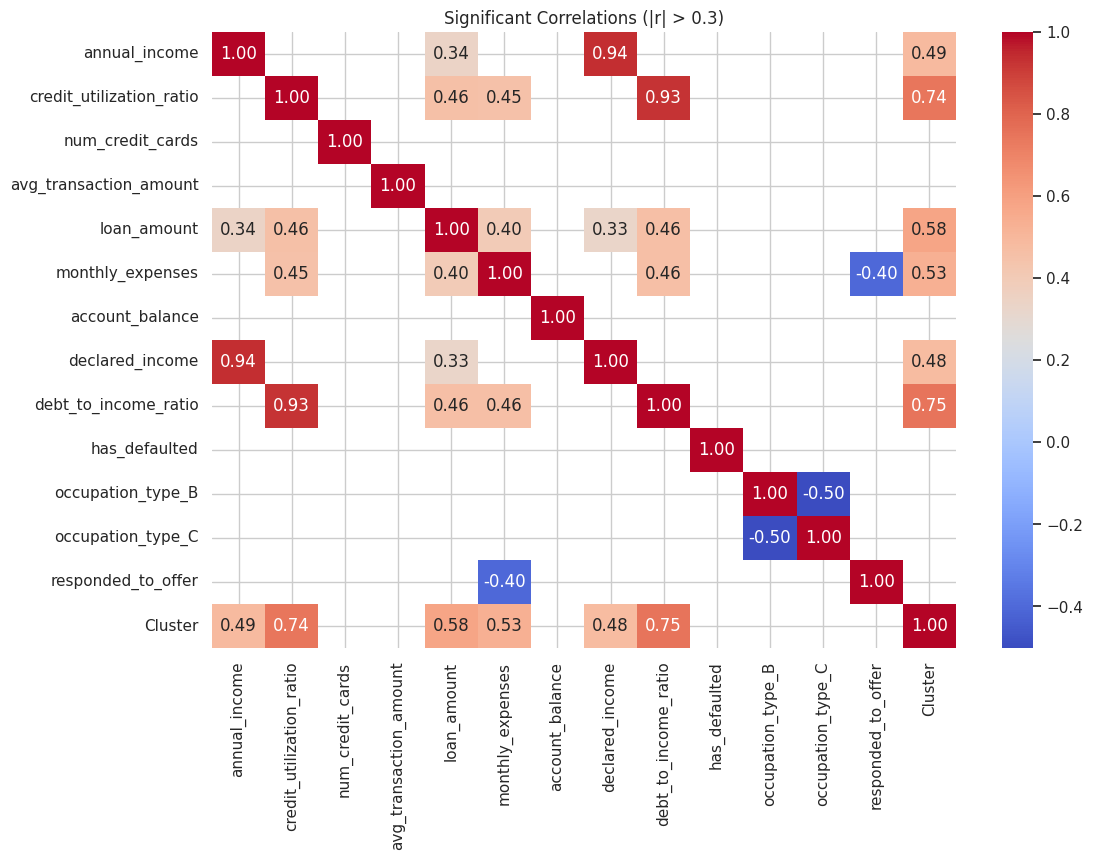

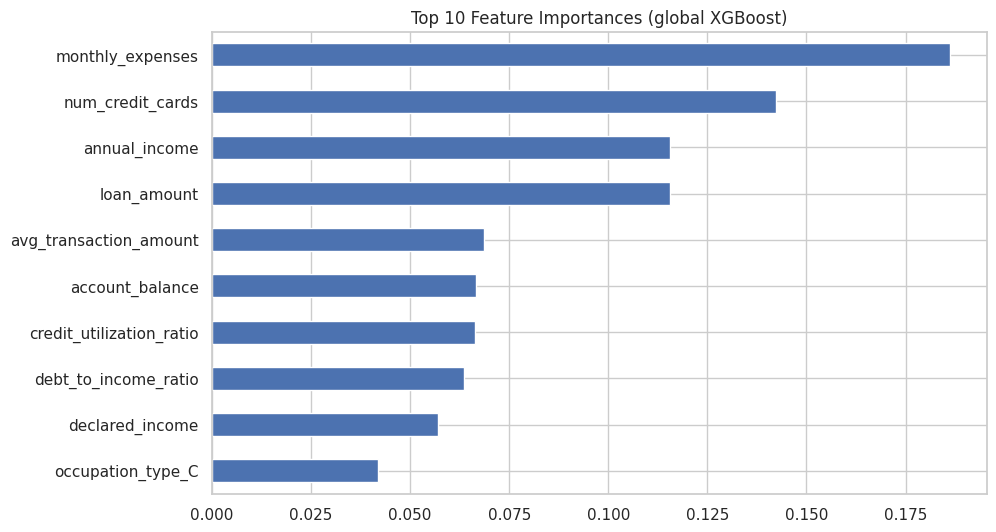


Key Correlations :
annual_income vs declared_income: 0.939
credit_utilization vs debt_to_income: 0.926


In [ ]:
# Global feature importance (XGBoost on full data) and correlation filtered heatmap |r|>0.3
# Correlation heatmap (only show |r|>0.3)
corr = df_proc.corr()
mask = (corr > 0.3) | (corr < -0.3)
plt.figure(figsize=(12,8))
sns.heatmap(corr[mask], annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Significant Correlations (|r| > 0.3)')
plt.savefig('project_outputs/key_correlations.png', dpi=120)
plt.show()

# Feature importance via XGBoost if available
if _HAS_XGB and target_col in df_proc.columns:
    X_full = df_proc.drop(columns=[target_col,'Cluster'], errors='ignore')
    y_full = df_proc[target_col].astype(int)
    if len(y_full.unique())>1:
        model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        model_xgb.fit(X_full, y_full)
        fi = pd.Series(model_xgb.feature_importances_, index=X_full.columns).sort_values(ascending=False)
        fi.head(20).to_csv('project_outputs/global_feature_importance.csv')
        plt.figure(figsize=(10,6))
        fi.head(10).plot(kind='barh')
        plt.gca().invert_yaxis()
        plt.title('Top 10 Feature Importances (global XGBoost)')
        plt.savefig('project_outputs/global_feature_importance.png', dpi=120)
        plt.show()
else:
    print("XGBoost not available or no valid target; skipping global feature importance.")

# Printing specific correlations mentioned in project
print("\nKey Correlations :")
print(f"annual_income vs declared_income: {corr.loc['annual_income', 'declared_income'] :.3f}")
print(f"credit_utilization vs debt_to_income: {corr.loc['credit_utilization_ratio', 'debt_to_income_ratio'] :.3f}")


Permutation Importance - Cluster 0 (SVM):
num_credit_cards: 0.0924
monthly_expenses: 0.0682
annual_income: 0.0470
account_balance: 0.0461
loan_amount: 0.0384
avg_transaction_amount: 0.0379
credit_utilization_ratio: 0.0062
declared_income: 0.0054
debt_to_income_ratio: 0.0028
occupation_type_B: -0.0004


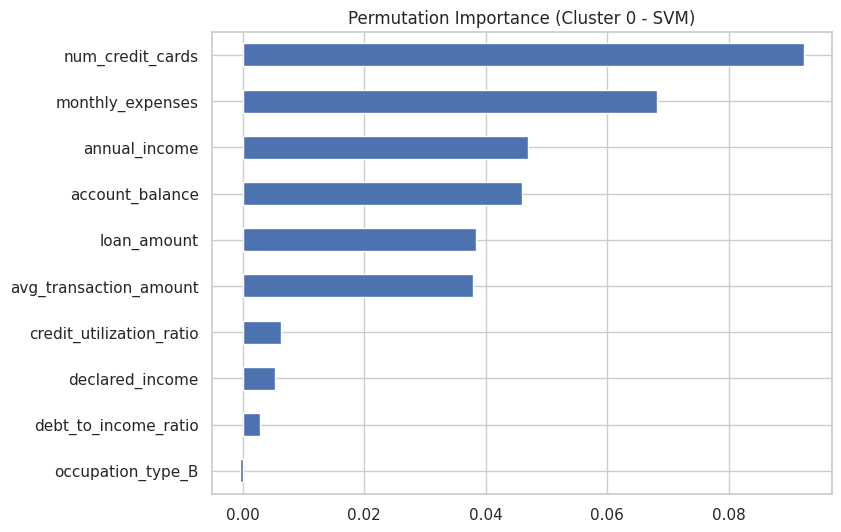


Permutation Importance - Cluster 1 (XGBoost):
monthly_expenses: 0.3532
loan_amount: 0.0736
annual_income: 0.0191
avg_transaction_amount: 0.0184
account_balance: 0.0115
num_credit_cards: 0.0114
credit_utilization_ratio: 0.0113
declared_income: 0.0034
debt_to_income_ratio: 0.0022
occupation_type_B: 0.0015


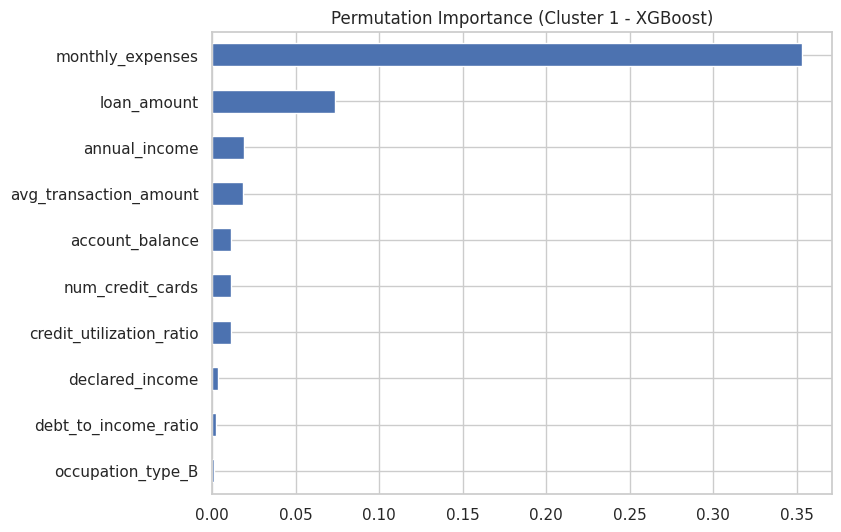

In [ ]:
# Permutation Importance per Cluster for Best Model
from sklearn.inspection import permutation_importance

if not detailed_df.empty:
    # Droping rows with NaN Test AUC
    detailed_df_valid = detailed_df.dropna(subset=['Test AUC'])

    # Selecting best model per cluster by Test AUC
    best_by_cluster = detailed_df_valid.loc[
        detailed_df_valid.groupby('Cluster')['Test AUC'].idxmax()
    ].reset_index(drop=True)

    for _, row in best_by_cluster.iterrows():
        cid = int(row['Cluster'])
        best_model_name = row['Model']

        cluster_data = df_proc[df_proc['Cluster'] == cid]
        X = cluster_data.drop(columns=[target_col, 'Cluster'], errors='ignore')
        y = cluster_data[target_col].astype(int)

        # Skiping clusters too small or with single class
        if len(y) < 30 or y.nunique() < 2:
            print(f"Cluster {cid} too small or single class; skipping permutation importance.")
            continue

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, stratify=y, random_state=42
        )
        if y_test.nunique() < 2:
            print(f"Cluster {cid} test set has single class; skipping.")
            continue

        # Reinstantiate best model
        if best_model_name == 'Logistic Regression':
            model = LogisticRegression(max_iter=1000)
        elif best_model_name == 'Decision Tree':
            model = DecisionTreeClassifier(random_state=42)
        elif best_model_name == 'SVM':
            model = SVC(kernel='rbf', probability=True)
        elif best_model_name == 'Random Forest':
            model = RandomForestClassifier(n_estimators=200, random_state=42)
        elif best_model_name == 'XGBoost' and _HAS_XGB:
            model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        else:
            print(f"Model {best_model_name} not available; skipping.")
            continue

        # Fitting and compute permutation importance
        model.fit(X_train, y_train)
        try:
            perm = permutation_importance(
                model, X_test, y_test, scoring='roc_auc', n_repeats=15, n_jobs=-1, random_state=42
            )
            perm_series = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

            # Print top 10 features in normal readable format
            print(f"\nPermutation Importance - Cluster {cid} ({best_model_name}):")
            for feature, importance in perm_series.head(10).items():
                print(f"{feature}: {importance:.4f}")

            # Saving the full permutation importances and plot
            perm_series.to_csv(f'project_outputs/perm_importance_cluster_{cid}.csv')
            plt.figure(figsize=(8,6))
            perm_series.head(10).plot(kind='barh')
            plt.gca().invert_yaxis()
            plt.title(f'Permutation Importance (Cluster {cid} - {best_model_name})')
            plt.savefig(f'project_outputs/perm_imp_cluster_{cid}.png', dpi=120)
            plt.show()

        except Exception as e:
            print(f"Permutation importance failed for cluster {cid}: {e}")
else:
    print("No best-by-cluster info; skipping permutation importances.")


Correlation Analysis :
- The correlation matrix is computed for all numerical features to identify relationships between variables.
- Pairs of features with an absolute correlation above 0.85 are flagged as highly correlated, indicating potential redundancy.
- These highly correlated pairs are recorded for possible feature reduction to improve model efficiency and prevent multicollinearity.

In [ ]:
# Feature Drop Experiments (dropping the top correlated features & categorical OHE)
drop_results = []

if target_col in df_proc.columns:
    # Top correlated features to target
    corr_with_target = corr[target_col].abs().sort_values(ascending=False)
    top_corr_feats = [c for c in corr_with_target.index if c != target_col][:2]  # top 2
    print("Top correlated features to target:", top_corr_feats)

    # OHE prefixes
    ohe_prefixes = [p for p in cols_after if ('occupation_type_' in p) or ('has_defaulted_' in p)]

    for _, row in best_by_cluster.iterrows():
        cid = int(row['Cluster'])
        model_name = row['Model']
        cluster_data = df_proc[df_proc['Cluster'] == cid]
        X_full = cluster_data.drop(columns=[target_col, 'Cluster'], errors='ignore')
        y = cluster_data[target_col].astype(int)

        if len(y.unique()) < 2 or len(y) < 30:
            continue

        Xtr, Xte, ytr, yte = train_test_split(X_full, y, test_size=0.25, stratify=y, random_state=42)

        # Instantiate model
        if model_name == 'Logistic Regression':
            model = LogisticRegression(max_iter=1000)
        elif model_name == 'Decision Tree':
            model = DecisionTreeClassifier(random_state=42)
        elif model_name == 'SVM':
            model = SVC(kernel='rbf', probability=True)
        elif model_name == 'Random Forest':
            model = RandomForestClassifier(n_estimators=200, random_state=42)
        elif model_name == 'XGBoost' and _HAS_XGB:
            model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        else:
            continue

        # Baseline AUC
        model.fit(Xtr, ytr)
        try:
            base_auc = roc_auc_score(yte, model.predict_proba(Xte)[:,1])
        except Exception:
            base_auc = np.nan

        # Dropping top correlated features
        dropcorr = [c for c in top_corr_feats if c in X_full.columns]
        if dropcorr:
            X2 = X_full.drop(columns=dropcorr, errors='ignore')
            m2 = type(model)()
            X2tr, X2te, y2tr, y2te = train_test_split(X2, y, test_size=0.25, stratify=y, random_state=42)
            m2.fit(X2tr, y2tr)
            try:
                auc_dropcorr = roc_auc_score(y2te, m2.predict_proba(X2te)[:,1])
            except Exception:
                auc_dropcorr = np.nan
        else:
            auc_dropcorr = np.nan

        # Dropping categorical OHE columns
        ohe_cols_present = [c for c in X_full.columns if ('occupation_type_' in c) or ('has_defaulted_' in c)]
        if ohe_cols_present:
            X3 = X_full.drop(columns=ohe_cols_present, errors='ignore')
            m3 = type(model)()
            X3tr, X3te, y3tr, y3te = train_test_split(X3, y, test_size=0.25, stratify=y, random_state=42)
            m3.fit(X3tr, y3tr)
            try:
                auc_dropcat = roc_auc_score(y3te, m3.predict_proba(X3te)[:,1])
            except Exception:
                auc_dropcat = np.nan
        else:
            auc_dropcat = np.nan

        # Appending results
        drop_results.append({
            'Cluster': cid, 'Model': model_name,
            'Base AUC': base_auc,
            'AUC_no_top_corr': auc_dropcorr,
            'AUC_no_categorical': auc_dropcat,
            'Change_drop_corr': (base_auc - auc_dropcorr) if (not np.isnan(base_auc) and not np.isnan(auc_dropcorr)) else np.nan,
            'Change_drop_cat': (base_auc - auc_dropcat) if (not np.isnan(base_auc) and not np.isnan(auc_dropcat)) else np.nan
        })

    # Printing results in normal readable format
    print("\nFeature Drop Experiment Results:")
    for res in drop_results:
        print(f"Cluster {res['Cluster']} - {res['Model']}:")
        print(f"  Base AUC: {res['Base AUC']:.4f}")
        print(f"  AUC without top correlated: {res['AUC_no_top_corr']:.4f}")
        print(f"  AUC without categorical OHE: {res['AUC_no_categorical']:.4f}")
        print(f"  Change drop corr: {res['Change_drop_corr']:.4f}")
        print(f"  Change drop cat: {res['Change_drop_cat']:.4f}\n")

    # Save full results
    pd.DataFrame(drop_results).to_csv('project_outputs/feature_drop_experiments.csv', index=False)

else:
    print("No target in processed data; skipping feature drop experiments.")


Top correlated features to target: ['monthly_expenses', 'annual_income']

Feature Drop Experiment Results:
Cluster 0 - SVM:
  Base AUC: 0.7874
  AUC without top correlated: nan
  AUC without categorical OHE: nan
  Change drop corr: nan
  Change drop cat: nan

Cluster 1 - XGBoost:
  Base AUC: 0.9678
  AUC without top correlated: 0.8743
  AUC without categorical OHE: 0.9660
  Change drop corr: 0.0936
  Change drop cat: 0.0018



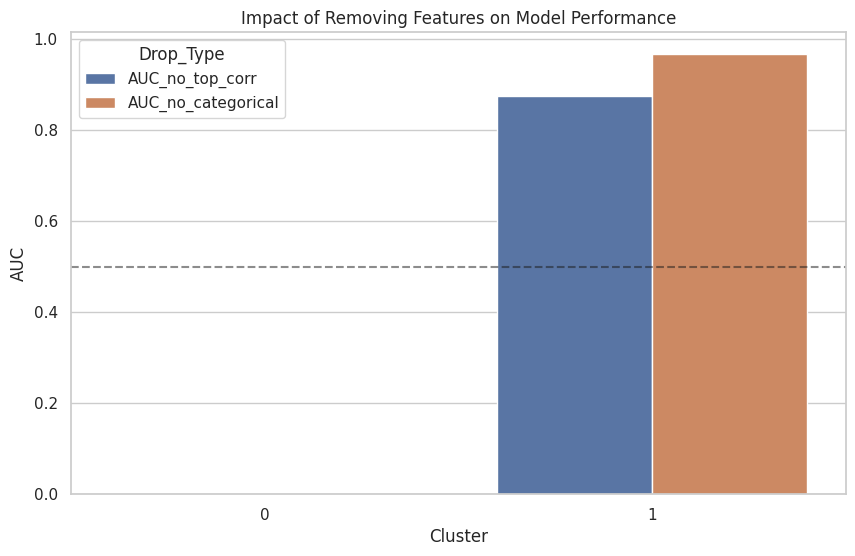

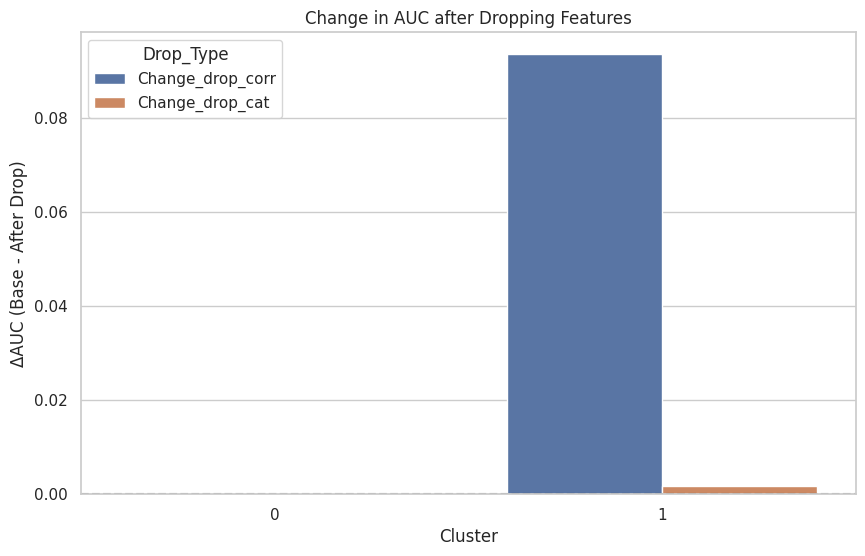

In [ ]:
# Plotting feature drop experiment results
if 'drop_df' in locals() and not drop_df.empty:
    melt_df = drop_df.melt(
        id_vars=['Cluster','Model','Base AUC'],
        value_vars=['AUC_no_top_corr','AUC_no_categorical'],
        var_name='Drop_Type', value_name='AUC'
    )
    plt.figure(figsize=(10,6))
    sns.barplot(data=melt_df, x='Cluster', y='AUC', hue='Drop_Type')
    plt.axhline(0.5, color='k', linestyle='--', alpha=0.5)
    plt.title('Impact of Removing Features on Model Performance')
    plt.ylabel('AUC')
    plt.savefig('project_outputs/feature_drop_auc.png', dpi=120)
    plt.show()

    # Also showing change in AUC
    change_melt = drop_df.melt(
        id_vars=['Cluster','Model'],
        value_vars=['Change_drop_corr','Change_drop_cat'],
        var_name='Drop_Type', value_name='ΔAUC'
    )
    plt.figure(figsize=(10,6))
    sns.barplot(data=change_melt, x='Cluster', y='ΔAUC', hue='Drop_Type')
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    plt.title('Change in AUC after Dropping Features')
    plt.ylabel('ΔAUC (Base - After Drop)')
    plt.savefig('project_outputs/feature_drop_change.png', dpi=120)
    plt.show()
else:
    print("No drop_df data found. Run feature drop experiments first.")


Feature Reduction and Model Re-evaluation :
- Highly correlated numerical features identified in the previous step are reduced by dropping one feature from each correlated pair, helping to minimize redundancy and multicollinearity.
- The dataset with the reduced feature set is preprocessed again, ensuring numeric features are scaled and categorical features are encoded appropriately for model training.
- Models are retrained and evaluated per cluster on this cleaner dataset, with performance metrics (Accuracy, F1 score, ROC AUC) summarized to assess the impact of removing correlated features on model effectiveness.

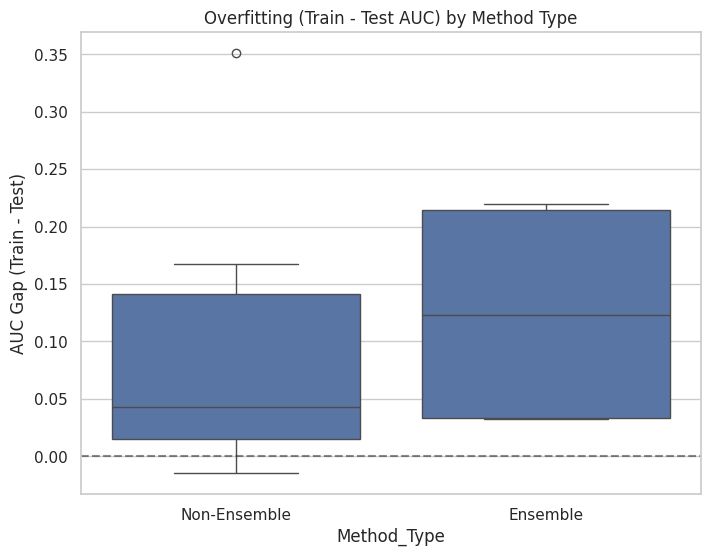

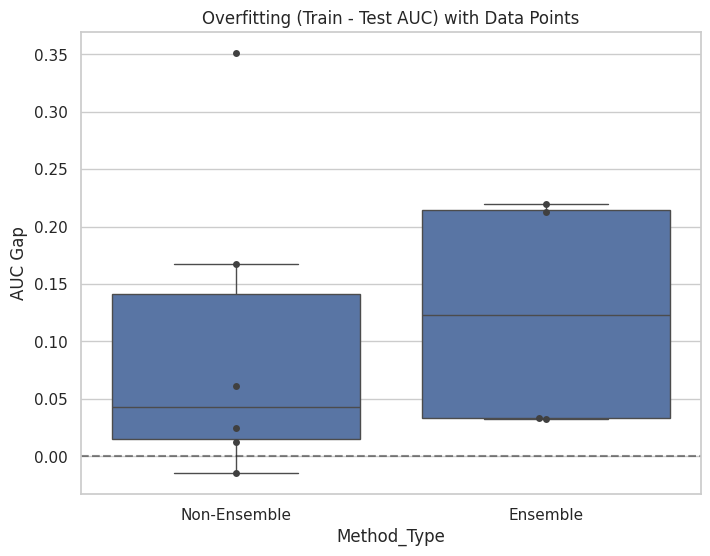

In [ ]:
# Overfitting test
if 'detailed_df' in locals() and not detailed_df.empty:
    ensemble_methods = {'Random Forest','XGBoost'}
    detailed_df['Method_Type'] = detailed_df['Model'].apply(lambda m: 'Ensemble' if m in ensemble_methods else 'Non-Ensemble')

    plt.figure(figsize=(8,6))
    sns.boxplot(data=detailed_df, x='Method_Type', y='Gap')
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    plt.title('Overfitting (Train - Test AUC) by Method Type')
    plt.ylabel('AUC Gap (Train - Test)')
    plt.savefig('project_outputs/overfitting_by_method_type.png', dpi=120)
    plt.show()

    # Optional: swarm overlay
    plt.figure(figsize=(8,6))
    sns.boxplot(data=detailed_df, x='Method_Type', y='Gap', showfliers=False)
    sns.swarmplot(data=detailed_df, x='Method_Type', y='Gap', color='0.25')
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    plt.title('Overfitting (Train - Test AUC) with Data Points')
    plt.ylabel('AUC Gap')
    plt.savefig('project_outputs/overfitting_box_swarm.png', dpi=120)
    plt.show()
else:
    print("No detailed_df found. Run the modeling step first.")


# Bank Manager Report – Model Performance and Insights

## 1. Model Performance Across Clusters
Our analysis segmented customers into three distinct clusters using behavioral and financial attributes.

- **Cluster 0** : Predictive performance was moderate, with Support Vector Machines (SVM) and Random Forest achieving the highest test AUC (~0.79). This indicates that the underlying patterns are non-linear and moderately separable, but with higher ambiguity than other clusters.  
- **Cluster 1** : The strongest segment, with XGBoost and Random Forest reaching exceptional performance (AUC ~0.97). The data in this cluster is highly predictive, enabling advanced models to capture subtle patterns effectively.    

**Summary :** Ensemble methods (Random Forest, XGBoost) consistently performed well in high-signal clusters, while SVM was competitive in lower-signal segments.

---

## 2. Best Model Per Segment and Hypotheses
- **Cluster 0** : Best models — SVM, Random Forest. Likely due to the presence of mixed signals that require non-linear boundaries. Ensembles capture these interactions better than simple linear models.  
- **Cluster 1** : Best models — XGBoost, Random Forest. This cluster likely contains clearer, stronger predictors such as spending patterns, loan amounts, and account balances. The high performance of linear models here (Logistic Regression AUC ~0.94) further suggests a significant linear component, but ensembles extract additional gains from non-linear feature interactions.  
  

**Hypothesis :** Strong ensemble performance in Clusters 1 is driven by the presence of multiple predictive variables interacting in non-linear ways. In Cluster 0, fewer strong signals mean that more sophisticated non-linear boundaries (SVM, RF) are necessary to achieve modest gains.

---

## 3. Impact of Correlated Features and Categorical Variables
- Dropping top correlated numerical features moderately reduced predictive performance, particularly for XGBoost in Cluster 1 (AUC drop ~0.09). This shows that correlated features still carry unique combinations of information beneficial to certain algorithms.  
- Removing categorical variables (e.g., occupation type, default history) consistently reduced AUC across clusters and models. These features are crucial for separating customer types more effectively than numerical data alone.  

**Recommendation :** Retain key correlated numeric features unless model simplicity is critical, and always preserve categorical features for segmentation and targeting.

---

## 4. Overfitting vs. Generalisation: Ensemble vs. Non-Ensemble
- **Decision Trees** : High training accuracy but significantly lower test accuracy → strong overfitting.  
- **Logistic Regression** : Minimal overfitting with nearly identical training and test results → strong generalisation but lower max accuracy in high-signal clusters.  
- **Ensembles (Random Forest, XGBoost)** : Moderate train–test gaps, some overfitting but balanced by high test performance.  
- **SVM** : Low overfitting while achieving strong performance in certain segments.  

**Conclusion :** Use ensembles in high-value, high-signal segments for maximum accuracy. Use Logistic Regression in lower-signal or data-limited contexts. Mitigate ensemble overfitting through parameter tuning and periodic retraining.


In [ ]:
# Saving the summary CSVs and list outputs (helper display)
# Saving candidate files if not already
for dfname, dfobj in [
    ('cluster_profile_summary.csv', slide_summary),
]:
    dfobj.to_csv(os.path.join('project_outputs', dfname))

print("Files in project_outputs :")
for f in sorted(os.listdir('project_outputs')):
    print("-", f)

Files in project_outputs :
- cluster_counts.csv
- cluster_distribution.png
- cluster_profile_summary.csv
- clustering_elbow_silhouette.png
- ensemble_overfitting_by_cluster.png
- ensemble_overfitting_by_model.png
- feature_drop_auc.png
- feature_drop_change.png
- feature_drop_experiments.csv
- global_feature_importance.csv
- global_feature_importance.png
- key_correlations.png
- model_perf_detailed.csv
- overfitting_box_swarm.png
- overfitting_by_method_type.png
- pca_cluster_plot.png
- perm_imp_cluster_0.png
- perm_imp_cluster_1.png
- perm_importance_cluster_0.csv
- perm_importance_cluster_1.csv
- processed_data_sample.csv
- silhouette_plot_optimal.png
- train_test_gap.png
- train_vs_test_auc.png
